<a href="https://colab.research.google.com/github/chandini2595/comprehensive-transfer-learning-experiments/blob/main/Colab/supervised_contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tensorflow==2.15.0 tensorflow-addons==0.23.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# BATCH_SIZE = 32
BATCH_SIZE = 1024 # batch_size for pre-training
PROJECTION_DIM = 128
# WRITE_SUMMARY = True
WRITE_SUMMARY = False

ACTIVATION = 'leaky_relu'
LR = 0.5 # learning rate for pre-training

In [10]:
!mkdir -p logs/

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=LR)
optimizer2 = tf.keras.optimizers.Adam() # with default lr

# 0. Load MNIST data

In [12]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
print(x_train.shape, x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


In [13]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [14]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# 1. Multi-class N-pairs loss

## Stage 1: train encoder with multiclass N-pair loss

In [16]:


class Encoder(tf.keras.Model):
    def __init__(self, normalize=True, activation='relu'):
        super(Encoder, self).__init__()
        self.normalize = normalize
        self.dense1 = tf.keras.layers.Dense(512, activation=activation) #, kernel_regularizer='l2') #, activity_regularizer='l2')
        self.dense2 = tf.keras.layers.Dense(256, activation=activation) #, activity_regularizer='l2')
        self.dense3 = tf.keras.layers.Dense(128, activation=activation) #, activity_regularizer='l2')

    def call(self, x, training=False):
        h = self.dense1(x)
        h = self.dense2(h)
        h = self.dense3(h)
        if self.normalize:
            h = tf.math.l2_normalize(h, axis=-1)
        return h

class Projector(tf.keras.Model):
    def __init__(self, projection_dim, normalize=True, activation='relu'):
        super(Projector, self).__init__()
        self.normalize = normalize
        self.dense1 = tf.keras.layers.Dense(projection_dim, activation=activation)
        # self.dense2 = tf.keras.layers.Dense(projection_dim, activation=activation) #, activity_regularizer='l2')

    def call(self, z, training=False):
        h = self.dense1(z)
        # h = self.dense2(h)
        if self.normalize:
            h = tf.math.l2_normalize(h, axis=-1)
        return h

In [17]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [18]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_npair(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.multiclass_npairs_loss(z, y)

    gradients = tape.gradient(loss,
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients,
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [19]:
@tf.function
def test_step_npair(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.multiclass_npairs_loss(z, y)
    test_loss(t_loss)

In [21]:
# Creating instances of Encoder and Projector classes
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [22]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 128])

In [23]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 128])

In [24]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 128) (10000, 128)


## Check learned embedding

In [25]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [26]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [27]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

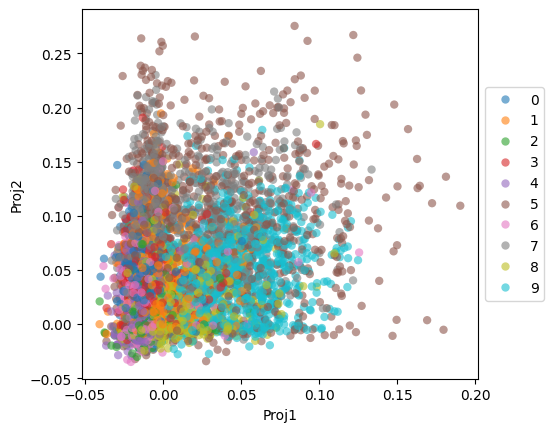

In [29]:
ax = sns.scatterplot(x='Proj1', y='Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

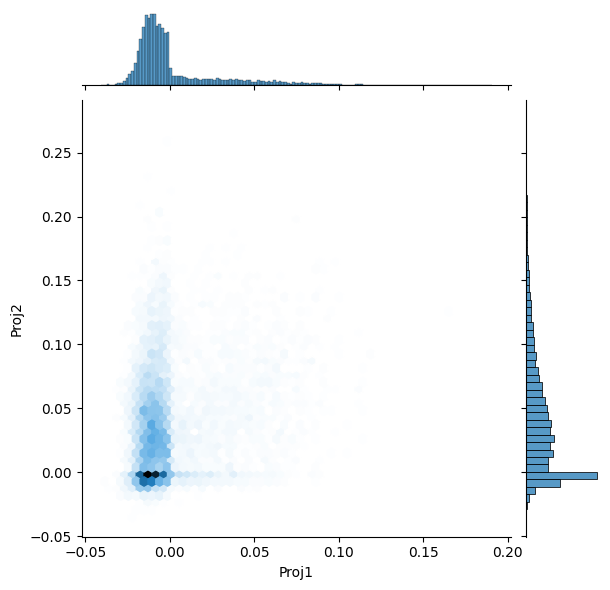

In [31]:
sns.jointplot(x='Proj1', y='Proj2', data=x_te_proj_df, kind="hex");

In [32]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

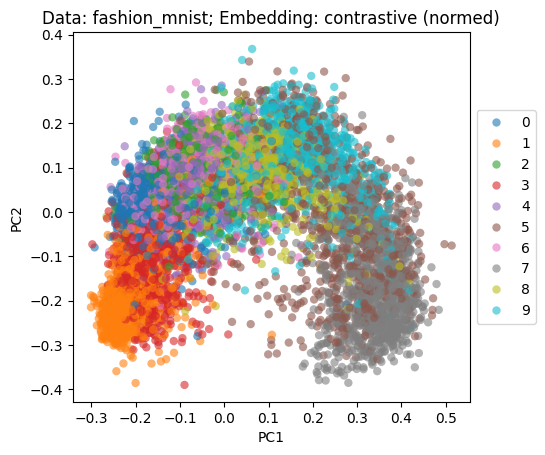

In [34]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='PC1', y='PC2',
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     #ax=ax # remove this line
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

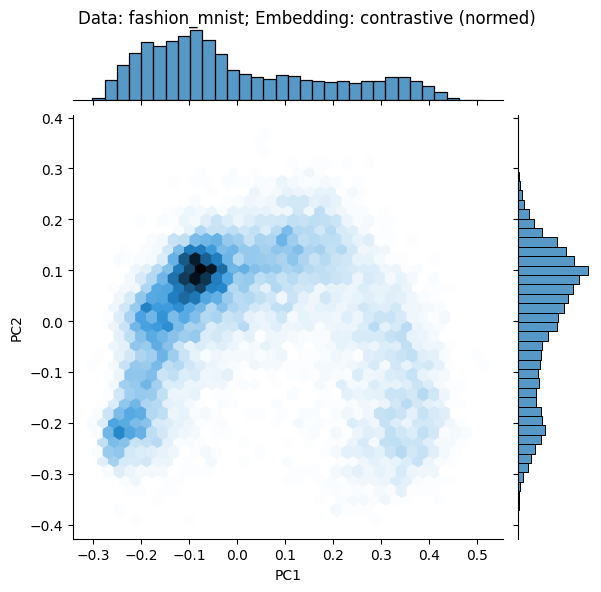

In [36]:
g = sns.jointplot(x='PC1', y='PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [37]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

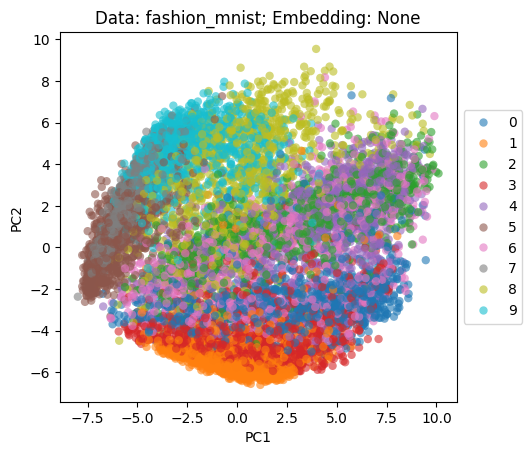

In [39]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='PC1', y='PC2', data=x_te_pca_df, # Changed the positional arguments to keyword arguments
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

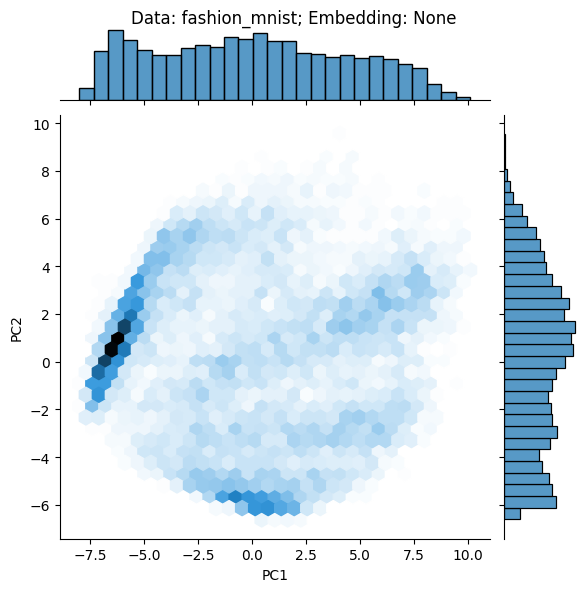

In [41]:
g = sns.jointplot(x='PC1', y='PC2', data=x_te_pca_df, # Changed positional arguments to keyword arguments
                  kind="hex"
                 );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [43]:
class SoftmaxPred(tf.keras.Model):
    def __init__(self):
        super(SoftmaxPred, self).__init__()
        self.dense1 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training=False):
        return self.dense1(x)

softmax = SoftmaxPred()

In [44]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [45]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [46]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              softmax.trainable_variables)
    optimizer2.apply_gradients(zip(gradients,
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [47]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [48]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [49]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Loss: 1.6508620977401733, Acc: 63.709999084472656, Test Loss: 1.2713152170181274, Test Acc: 69.58000183105469
Epoch 2, Loss: 1.0895428657531738, Acc: 72.08999633789062, Test Loss: 0.9790621995925903, Test Acc: 72.19999694824219
Epoch 3, Loss: 0.8912706971168518, Acc: 74.1066665649414, Test Loss: 0.8515243530273438, Test Acc: 73.63999938964844
Epoch 4, Loss: 0.7948980331420898, Acc: 75.33000183105469, Test Loss: 0.7833792567253113, Test Acc: 74.86000061035156
Epoch 5, Loss: 0.7394492626190186, Acc: 76.17166900634766, Test Loss: 0.7417498826980591, Test Acc: 75.51000213623047
Epoch 6, Loss: 0.7037813663482666, Acc: 76.79000091552734, Test Loss: 0.7139686346054077, Test Acc: 76.05999755859375
Epoch 7, Loss: 0.6787829995155334, Acc: 77.3066635131836, Test Loss: 0.6930292248725891, Test Acc: 76.4800033569336
Epoch 8, Loss: 0.6600630283355713, Acc: 77.63333129882812, Test Loss: 0.6776531934738159, Test Acc: 76.76000213623047
Epoch 9, Loss: 0.6453144550323486, Acc: 78.00333404541016,

In [50]:
test_acc.result().numpy()

0.7881

# 2. Supervised NT-Xent

In [51]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [53]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss,
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients,
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [54]:
@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [59]:
!pip install tensorflow-addons>=0.13.0  # Ensure tensorflow-addons is installed or upgraded
import tensorflow_addons as tfa

@tf.function
# train step for the supervised NT-Xent loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        # Call supervised_nt_xent_loss from the tfa.losses module
        loss = tfa.losses.contrastive.supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss,
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients,
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    # Call supervised_nt_xent_loss from the tfa.losses module
    t_loss = tfa.losses.contrastive.supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [60]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 128])

In [61]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 128])

In [62]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 128) (10000, 128)


## Check learned embedding

In [63]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [64]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [65]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

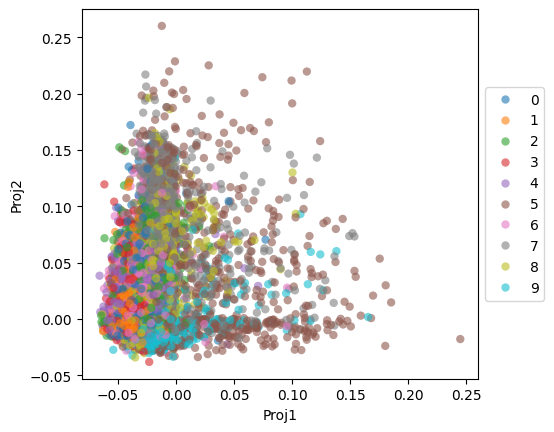

In [67]:
ax = sns.scatterplot(x='Proj1', y='Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

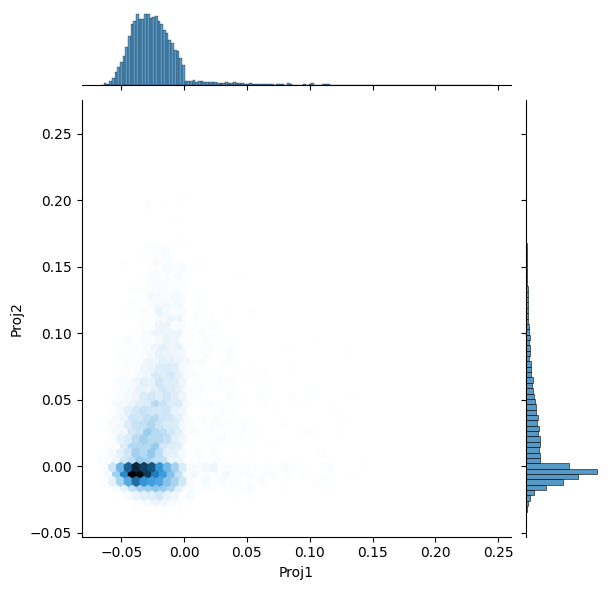

In [69]:
sns.jointplot(x='Proj1', y='Proj2', data=x_te_proj_df, kind="hex");

In [70]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

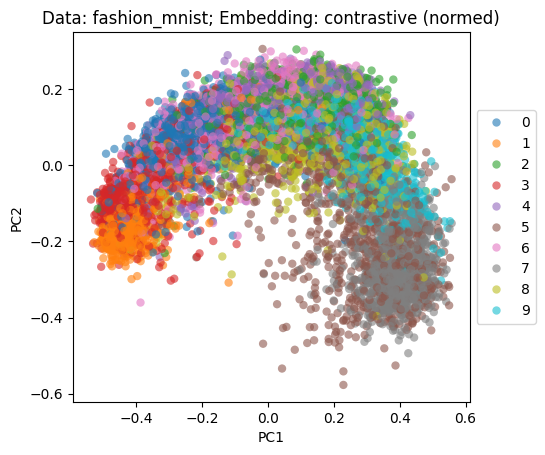

In [72]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='PC1', y='PC2',  # Changed 'PC1' and 'PC2' to keyword arguments
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

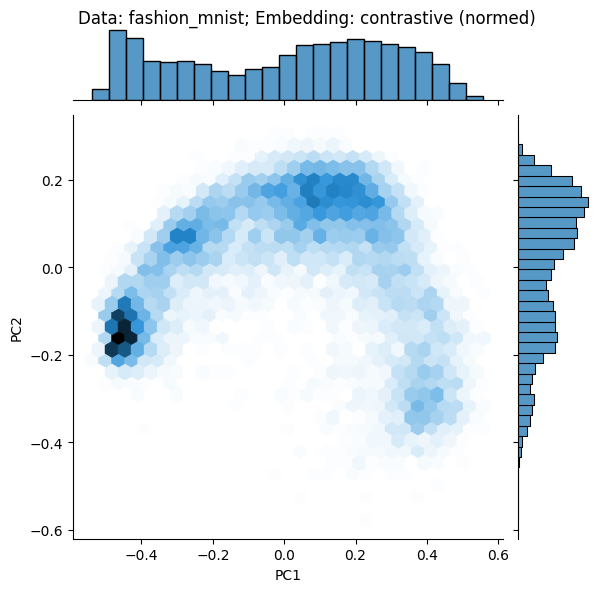

In [74]:
g = sns.jointplot(x='PC1', y='PC2', data=x_te_proj_pca_df, # Changed positional arguments to keyword arguments
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [75]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

TypeError: scatterplot() got multiple values for argument 'data'

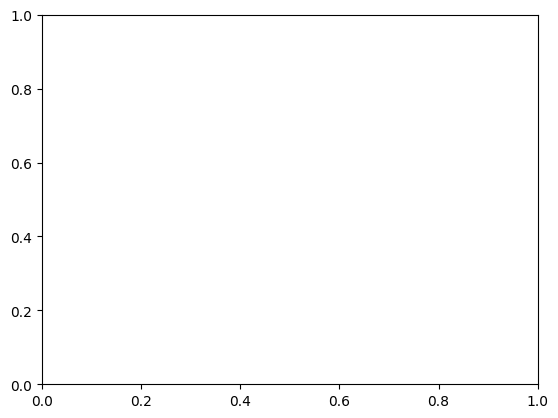

In [76]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

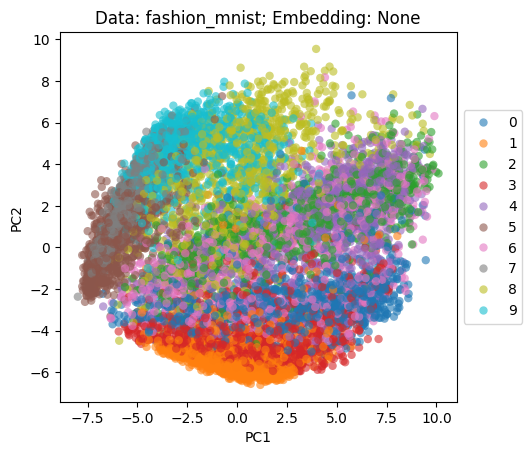

In [77]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='PC1', y='PC2', data=x_te_pca_df, # Changed 'PC1' and 'PC2' to keyword arguments
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [78]:
softmax = SoftmaxPred()

In [79]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [80]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [81]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              softmax.trainable_variables)
    optimizer2.apply_gradients(zip(gradients,
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [82]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [83]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [85]:
softmax = SoftmaxPred()
# Build the optimizer with the trainable variables of the softmax model
optimizer2.build(softmax.trainable_variables)

In [89]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        test_loss.result(),
                        test_acc.result() * 100))

Epoch 1, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 2, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 3, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 4, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 5, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 6, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 7, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 8, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 9, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 10, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 11, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 12, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 13, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 14, Test Loss: 2.2976462841033936, Test Acc: 18.690000534057617
Epoch 15, Test Loss: 2.297646